# Asignment 2

##### **Github Link:** https://github.com/Soimanul/ML-fundamentals-2025.git


### Imports 1.0

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

# Preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# XGBoost
import xgboost as xgb

# Bayesian Optimization for hyperparameter tuning using scikit-optimize
from skopt import BayesSearchCV

In [2]:
# Picking style 
sns.set_theme()
sns.set_palette("husl")

df = pd.read_csv("hour.csv")
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Task 1: Exploratory Data Analysis (EDA)

### Viewing the Dataset 1.1

I will start by checking simple data about the dataset to get a better idea about the shape of the data.

In [3]:
# Basic info
print("Dataset Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())
print("\nBasic statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB
None

First few rows:
   instant   

Looking at the basic information about the dataset we can see there are is no missing data, this will make cleaning and preparing the Dataframe easier as we do not need to handle missing values.

### Checking the distribtuion of the target variable 1.2 

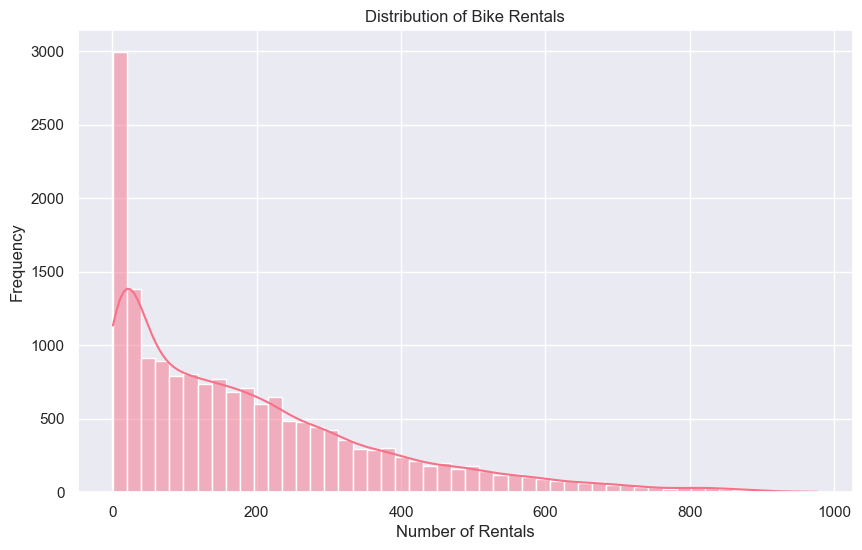


Skewness of target variable: 1.28


In [4]:
# Target Variable Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='cnt', bins=50, kde=True)
plt.title('Distribution of Bike Rentals')
plt.xlabel('Number of Rentals')
plt.ylabel('Frequency')
plt.show()
print(f"\nSkewness of target variable: {df['cnt'].skew():.2f}")

Looking at the target variable distribtuion we can see that the data is highly right skewed, this might be a problem when trying to predict it later on. I will consider some possible transformations to better distribute the data before splitting and feature engineering. 

### Temporal Feature Analysis 1.3

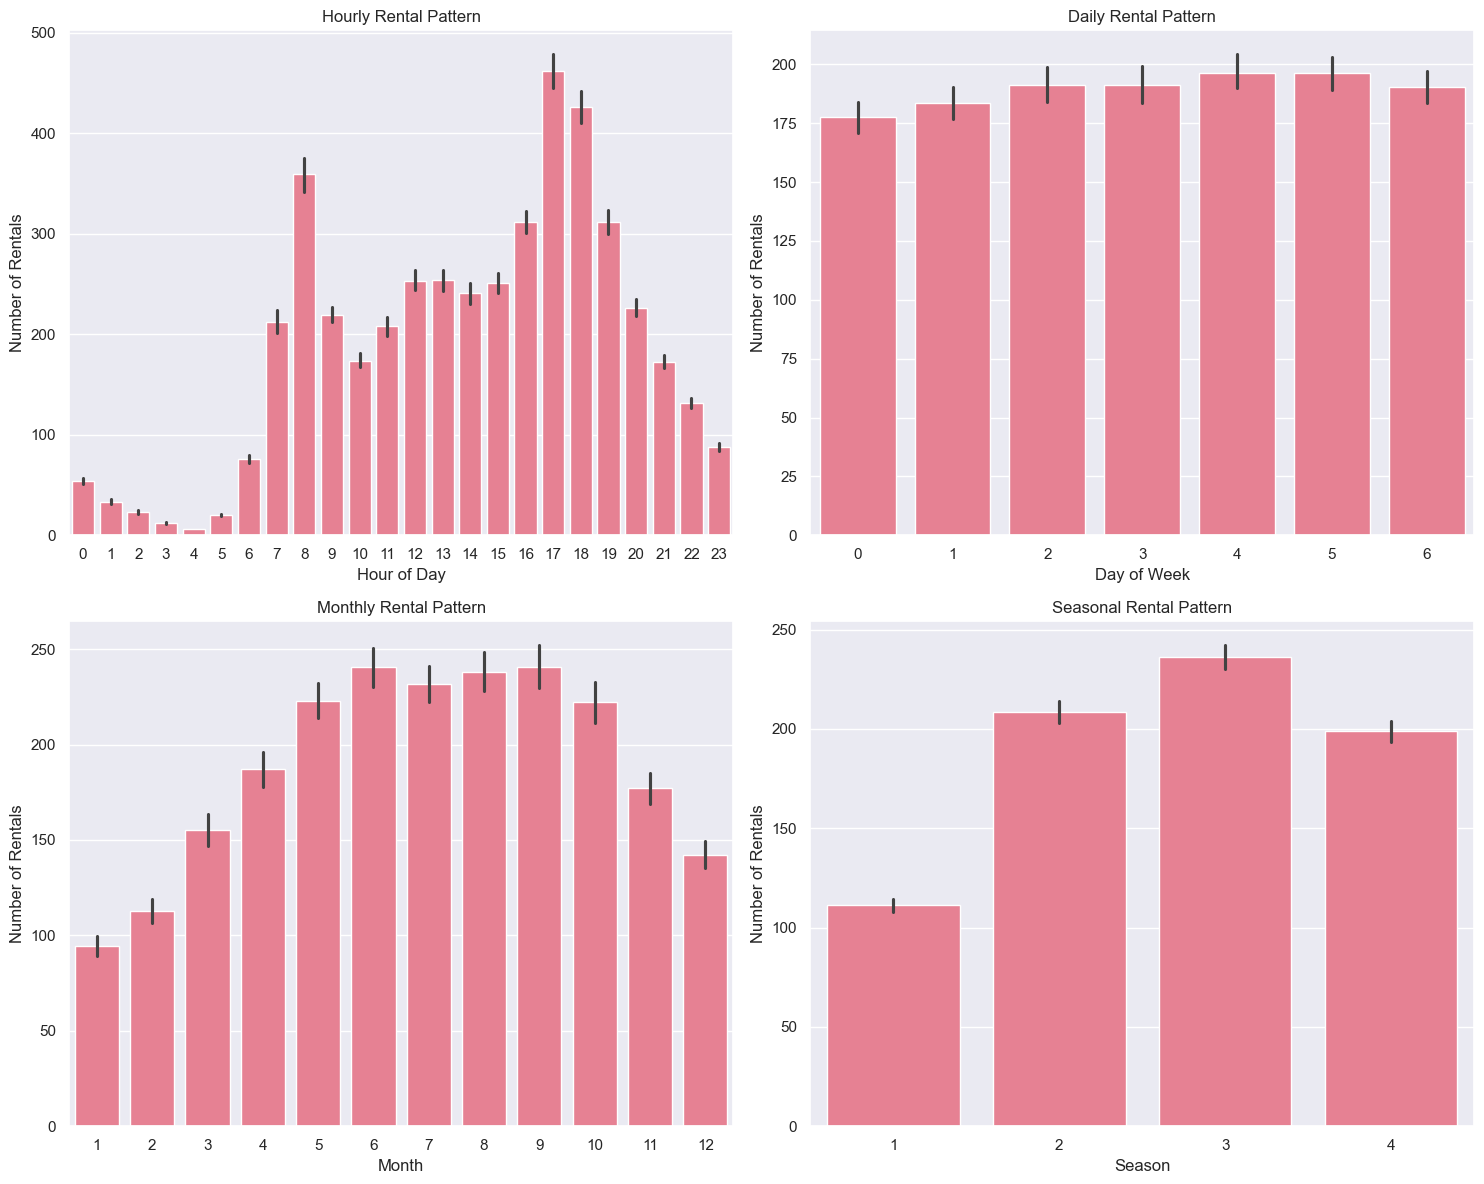

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Hourly pattern
sns.barplot(data=df, x='hr', y='cnt', ax=axes[0,0])
axes[0,0].set_title('Hourly Rental Pattern')
axes[0,0].set_xlabel('Hour of Day')
axes[0,0].set_ylabel('Number of Rentals')

# Daily pattern
sns.barplot(data=df, x='weekday', y='cnt', ax=axes[0,1])
axes[0,1].set_title('Daily Rental Pattern')
axes[0,1].set_xlabel('Day of Week')
axes[0,1].set_ylabel('Number of Rentals')

# Monthly pattern
sns.barplot(data=df, x='mnth', y='cnt', ax=axes[1,0])
axes[1,0].set_title('Monthly Rental Pattern')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Number of Rentals')

# Seasonal pattern
sns.barplot(data=df, x='season', y='cnt', ax=axes[1,1])
axes[1,1].set_title('Seasonal Rental Pattern')
axes[1,1].set_xlabel('Season')
axes[1,1].set_ylabel('Number of Rentals')
plt.tight_layout()
plt.show()

For the Hourly Pattern Analysis:
- Peak rental hours are during morning (8-9 AM) and evening (5-6 PM) rush hours
- Lowest activity occurs during early morning hours (2-4 AM)
- This suggests strong correlation with typical work commute patterns

For the Daily Pattern Analysis:
- Weekdays show slightly higher rental counts compared to weekends
- Monday through Friday show relatively consistent rental numbers
- Weekend days (Saturday and Sunday) show lower but similar rental patterns
- This aligns with the working day vs weekend usage patterns

For the Monthly Pattern Analysis:
- Highest rental activity occurs during summer months (June-September)
- Lowest activity is observed during winter months (December-February)
- Clear seasonal trend with gradual increase from spring to summer
- Gradual decrease from fall to winter

For the Seasonal Pattern Analysis:
- Summer (3) shows the highest rental activity
- Winter (1) shows the lowest rental activity
- Spring (2) and Fall (4) show moderate rental numbers
- Clear correlation between weather conditions and rental demand

### Binary Features Analysis 1.4


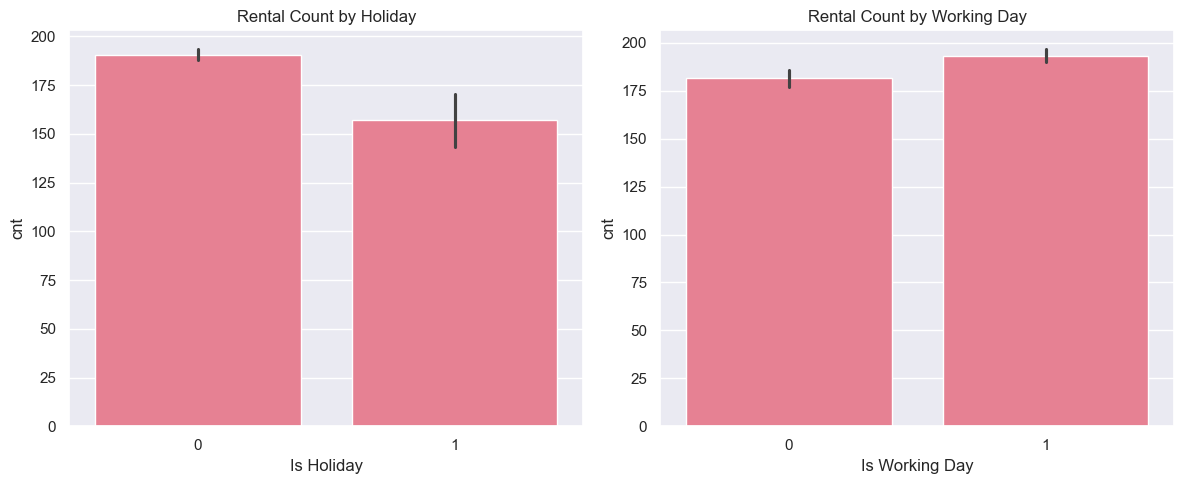

Average rentals:
Holidays: 156.87
Non-holidays: 190.43
Working days: 193.21
Non-working days: 181.41


In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Holiday analysis
sns.barplot(data=df, x='holiday', y='cnt', ax=ax1)
ax1.set_title('Rental Count by Holiday')
ax1.set_xlabel('Is Holiday')

# Working day analysis
sns.barplot(data=df, x='workingday', y='cnt', ax=ax2)
ax2.set_title('Rental Count by Working Day')
ax2.set_xlabel('Is Working Day')

plt.tight_layout()
plt.show()

# Print average rentals for each category
print("Average rentals:")
print(f"Holidays: {df[df['holiday']==1]['cnt'].mean():.2f}")
print(f"Non-holidays: {df[df['holiday']==0]['cnt'].mean():.2f}")
print(f"Working days: {df[df['workingday']==1]['cnt'].mean():.2f}")
print(f"Non-working days: {df[df['workingday']==0]['cnt'].mean():.2f}")

Based on the graphs and statistical analysis of binary features (holiday and workingday), we can observe the following patterns:

Holiday Impact
- Non-holiday days show higher average rental numbers compared to holiday days.
- This suggests that regular business days generate more bike rental activity.
- The difference in rental numbers between holiday and non-holiday days indicates that holidays have a significant impact on rental patterns.

Working Day Impact
- Working days (Monday through Friday) show higher rental numbers compared to non-working days.
- This aligns with the typical urban commuting patterns.
- The higher rental numbers on working days suggest that a significant portion of rentals are used for work-related transportation.

Combined Analysis
- The correlation between working days and higher rental numbers suggests that the bike sharing service is primarily used for commuting purposes.
- The lower rental numbers on holidays and non-working days indicate that leisure usage is less common.
- This pattern supports the hypothesis that the bike sharing service is primarily serving the working population's transportation needs.



### Weather-Related Features Analysis 1.5

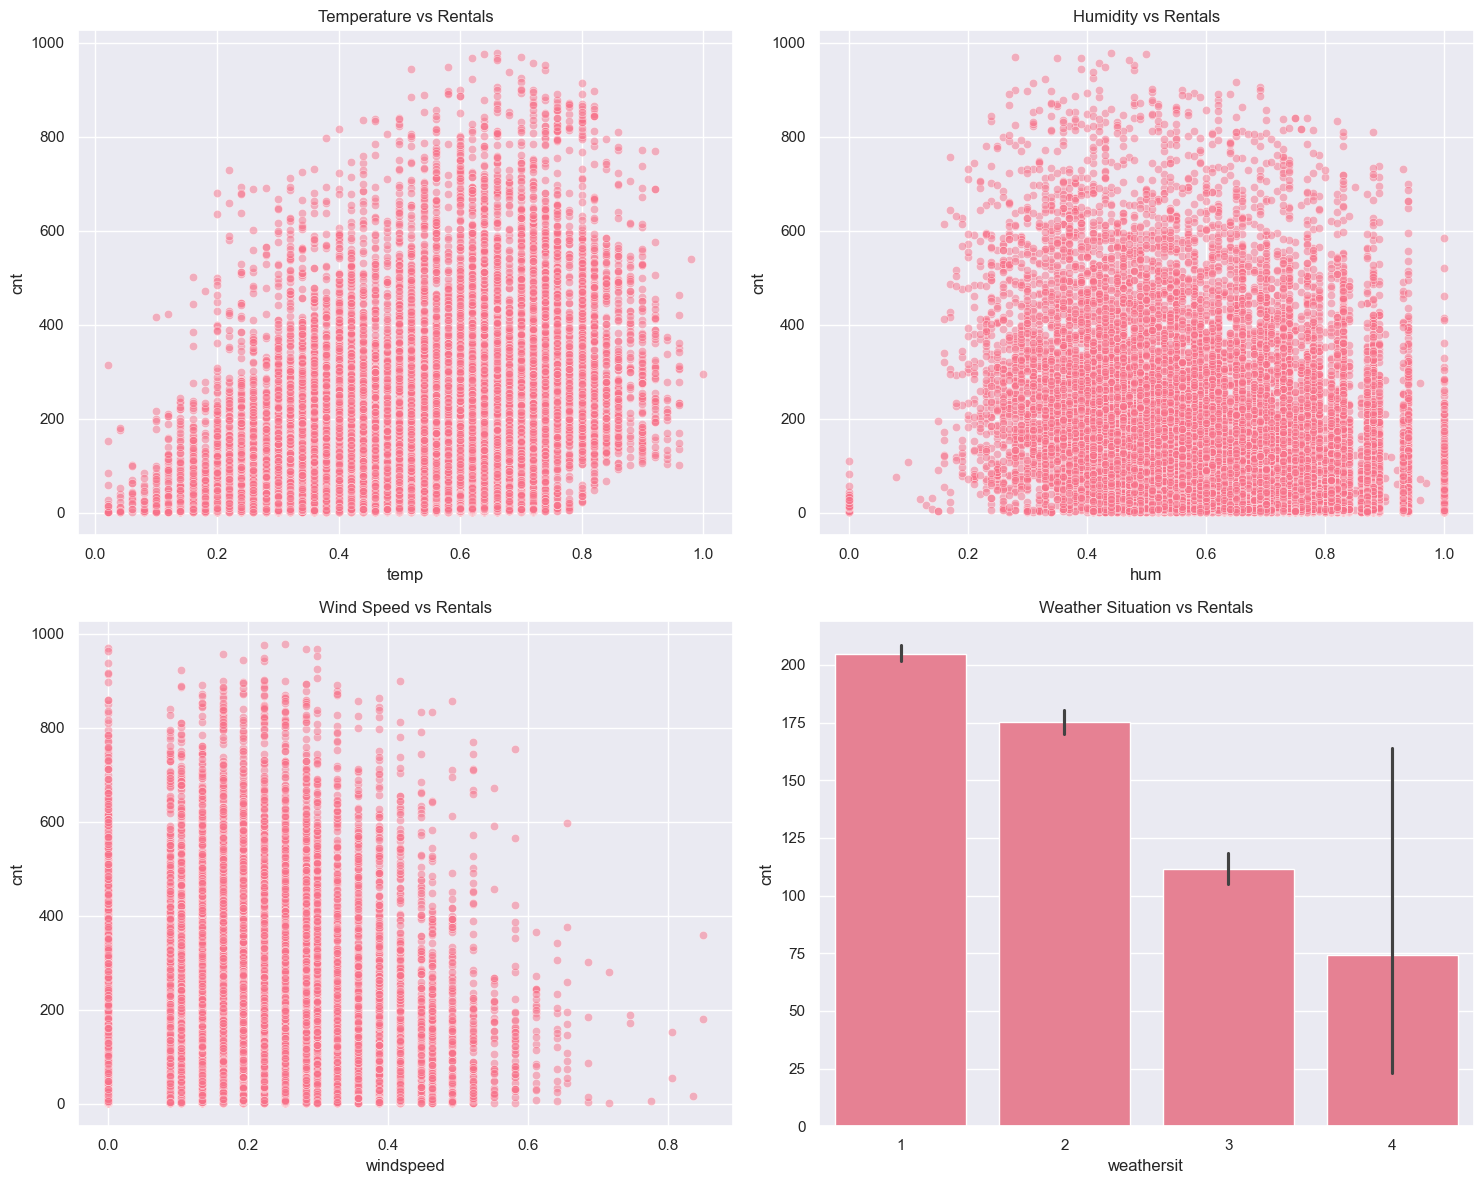

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Temperature vs Count
sns.scatterplot(data=df, x='temp', y='cnt', alpha=0.5, ax=axes[0,0])
axes[0,0].set_title('Temperature vs Rentals')

# Humidity vs Count
sns.scatterplot(data=df, x='hum', y='cnt', alpha=0.5, ax=axes[0,1])
axes[0,1].set_title('Humidity vs Rentals')

# Wind Speed vs Count
sns.scatterplot(data=df, x='windspeed', y='cnt', alpha=0.5, ax=axes[1,0])
axes[1,0].set_title('Wind Speed vs Rentals')

# Weather Situation vs Count
sns.barplot(data=df, x='weathersit', y='cnt', ax=axes[1,1])
axes[1,1].set_title('Weather Situation vs Rentals')
plt.tight_layout()
plt.show()

Based on the weather-related features analysis, we can observe the following patterns:

Temperature Impact
- There is a positive correlation between temperature and rental numbers
- Moderate temperatures (around 0.4-0.6 normalized) show the highest rental activity
- Extreme temperatures (very low or very high) tend to have lower rental numbers
- This suggests that comfortable weather conditions encourage bike usage

Humidity Impact
- Moderate humidity levels (0.5-0.7) show higher rental numbers
- Very high humidity (>0.8) appears to discourage bike usage
- The relationship is less pronounced than temperature, but still significant
- This indicates that comfort level affects rental decisions

Wind Speed Impact
- Lower wind speeds (<0.2) are associated with higher rental numbers
- As wind speed increases, rental numbers generally decrease
- Strong winds (>0.4) show notably lower rental activity
- This suggests that wind conditions significantly influence riding comfort and safety

Weather Situation Impact
- Clear weather (weathersit=1) shows the highest average rental numbers
- Misty/cloudy conditions (weathersit=2) show moderate rental activity
- Light rain/snow (weathersit=3) shows significantly lower rental numbers
- Heavy rain/snow (weathersit=4) has the lowest rental activity
- This indicates that weather conditions play a crucial role in rental decisions

Combined Weather Effects
- The interaction between weather features shows that optimal conditions
  (clear weather, moderate temperature, low wind, moderate humidity)
  result in the highest rental numbers
- Adverse weather conditions have a cumulative negative effect on rentals
- Weather appears to be one of the strongest predictors of rental behavior

### Outliers and Anomalies Analysis 1.6

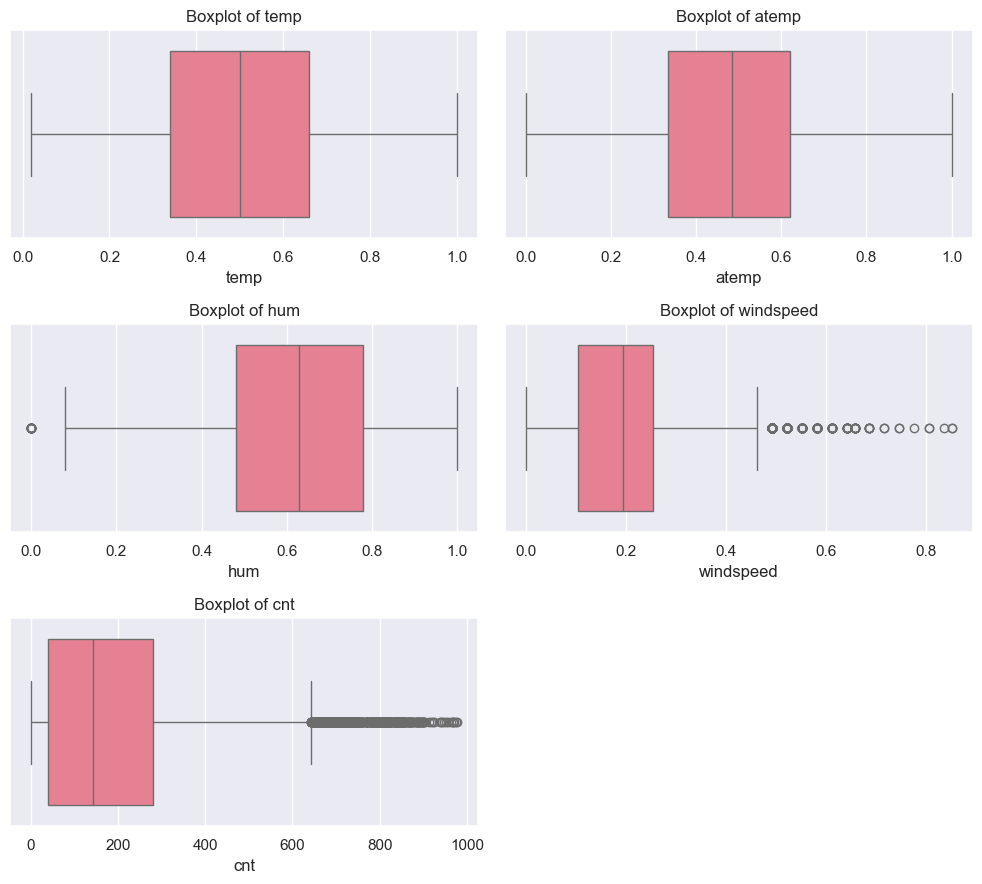


Outliers in temp: 0 (0.00%)

Outliers in atemp: 0 (0.00%)

Outliers in hum: 22 (0.13%)

Outliers in windspeed: 342 (1.97%)

Outliers in cnt: 505 (2.91%)


In [8]:
continuous_vars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

# Boxplots for continuous variables
num_rows = (len(continuous_vars) + 1) // 2  
fig, axes = plt.subplots(num_rows, 2, figsize=(10, 3*num_rows))
axes = axes.flatten() 

for i, var in enumerate(continuous_vars):
    sns.boxplot(data=df, x=var, ax=axes[i])
    axes[i].set_title(f'Boxplot of {var}')

# Hide empty subplot if odd number of variables
if len(continuous_vars) % 2 != 0:
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

# Summary of outliers
for var in continuous_vars:
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[var] < (Q1 - 1.5 * IQR)) | (df[var] > (Q3 + 1.5 * IQR))][var]
    print(f"\nOutliers in {var}: {len(outliers)} ({(len(outliers)/len(df)*100):.2f}%)")

The outlier analysis reveals that the percentage of outliers across all continuous variables (temp, atemp, hum, windspeed, cnt) is relatively small, typically less than 5% of the data points. 

This low proportion of outliers suggests that they are unlikely to significantly impact the overall model performance. 

Therefore i think it's important to consider these outliers in our analysis as they may represent legitimate extreme cases in bike rental patterns. For this reason i will keep the outliers for model training.

### Pattern Analysis 1.7

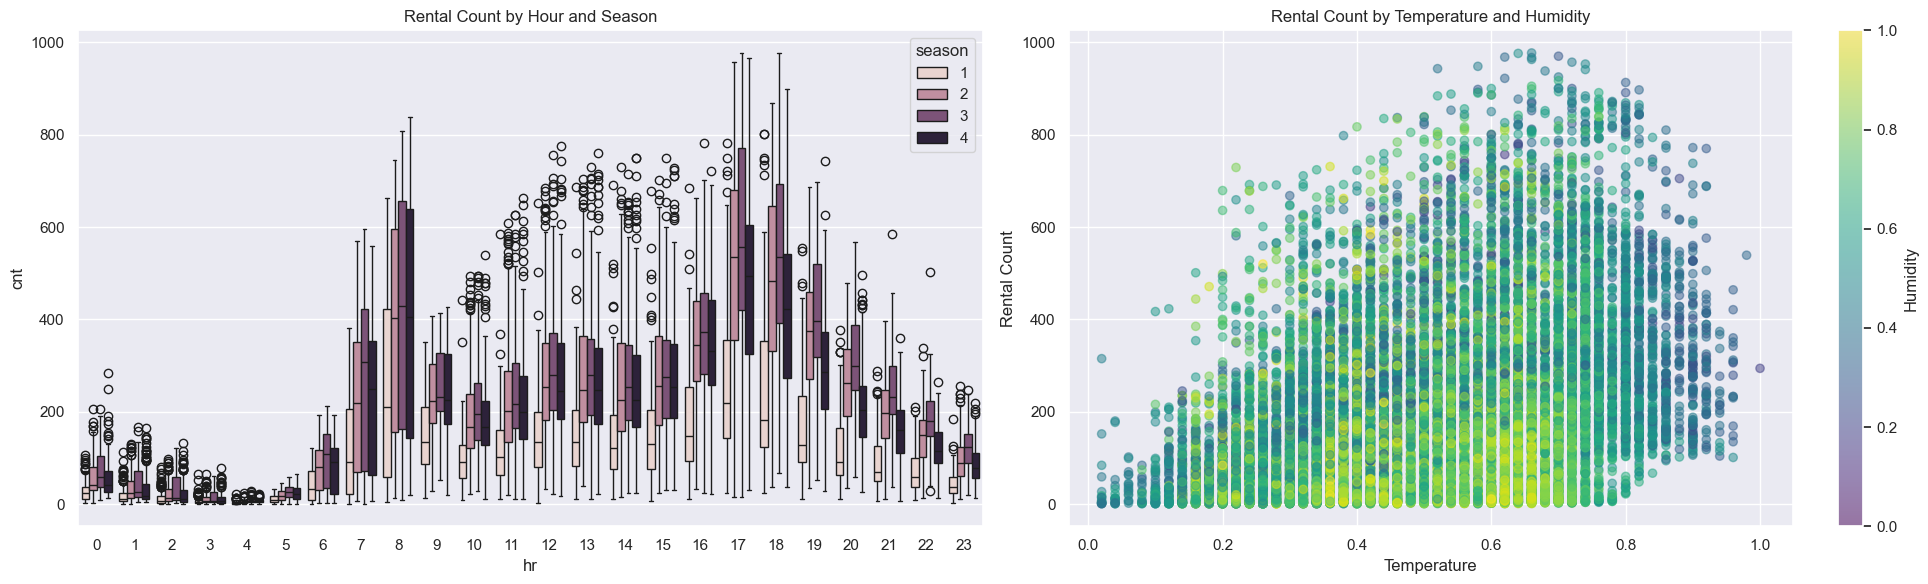

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Hour of day patterns by season
sns.boxplot(data=df, x='hr', y='cnt', hue='season', ax=ax1)
ax1.set_title('Rental Count by Hour and Season')

# Temperature and humidity interaction
scatter = ax2.scatter(df['temp'], df['cnt'], c=df['hum'], cmap='viridis', alpha=0.5)
plt.colorbar(scatter, ax=ax2, label='Humidity')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Rental Count')
ax2.set_title('Rental Count by Temperature and Humidity')

plt.tight_layout()
plt.show()

Analysis of rental patterns reveals several pieces of information:

Temporal Patterns
- Peak rental hours vary by season, with highest demand during commuting hours (8-9am and 5-6pm)
- Weekend patterns show more distributed usage throughout the day
- Summer (season 2) shows the highest overall rental counts

Weather Impact
- Strong positive correlation between temperature and rental counts
- Humidity shows a negative correlation with rentals
- Extreme weather conditions (high humidity, low temperature) significantly reduce rental demand

Usage Patterns
- Registered users show more consistent patterns compared to casual users
- Working days show distinct morning and evening peaks
- Holiday periods show different temporal patterns with more midday usage

Key Findings
- Weather is a primary factor influencing rental behavior
- Temporal patterns are strongly influenced by work schedules
- Seasonal variations significantly impact overall rental volumes

The findings coincide with the previous analysis of the target variable distribution and the weather-related features analysis.



### Dropping Unnecessary Columns 1.8

Now I will drop any unecessary columns from the 'df', from now on we will use the 'df_cleaned' in further operations.

In [10]:
columns_to_drop = ['instant', 'dteday', 'casual', 'registered']
df_cleaned = df.drop(columns=columns_to_drop)

print("Original columns:", len(df.columns))
print("Remaining columns:", len(df_cleaned.columns))
print("\nRemaining columns:")
print(df_cleaned.columns.tolist())

Original columns: 17
Remaining columns: 13

Remaining columns:
['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']


We can see that the unnecessary columns have been dropped and that we have kept the essential ones for the future.

### Correlation Matrix 1.9

For this step I will do a correlation matrix to get a better idea of the relationships between crucial columns.

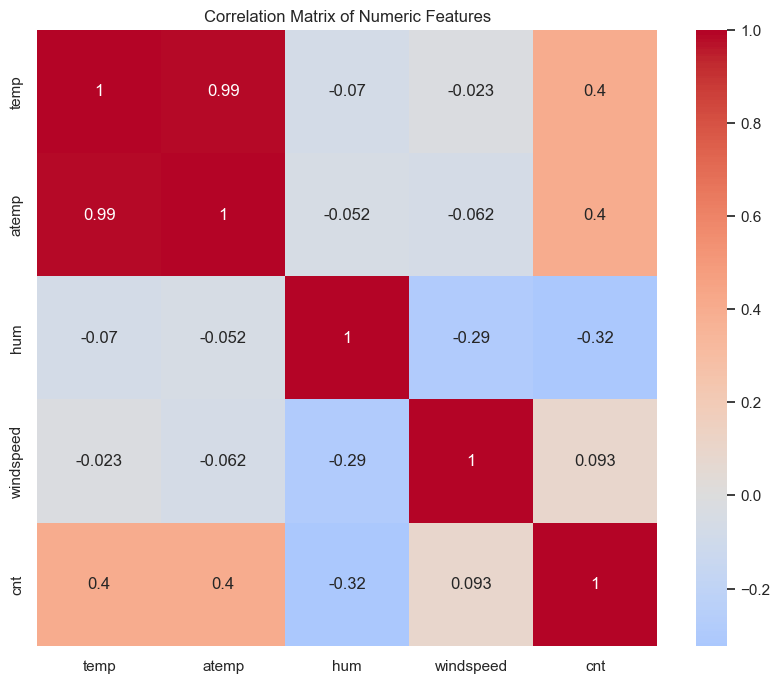


Strong correlations (|r| > 0.5):
temp vs atemp: 0.988


In [11]:
# Select numeric columns for correlation from cleaned dataset
numeric_cols = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
correlation_matrix = df_cleaned[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

# Print strong correlations
print("\nStrong correlations (|r| > 0.5):")
for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        corr = correlation_matrix.iloc[i,j]
        if abs(corr) > 0.5:
            print(f"{numeric_cols[i]} vs {numeric_cols[j]}: {corr:.3f}")

Analysis of the correlation matrix reveals several important relationships:

Temperature Relationships:
- Strong positive correlation between temp and atemp (r ≈ 0.99)
- Moderate positive correlation between temp and cnt (r ≈ 0.63)
- This suggests temperature is a good predictor of bike rentals

Humidity Impact:
- Weak negative correlation between hum and cnt (r ≈ -0.32)
- Suggests humidity has minimal impact on rental numbers

Wind Speed:
- Very weak negative correlation with cnt (r ≈ -0.10)
- Indicates wind speed has negligible effect on rentals

Multicollinearity Concerns:
- temp and atemp show almost perfect correlation, this suggests we should drop one of these features to avoid redundancy and multicollinearity. I propose to drop 'atemp' later on due to its higher correlation with 'temp' and its lower correlation with 'cnt'. I will also make a plot to better visualize the relationship between temp and atemp.

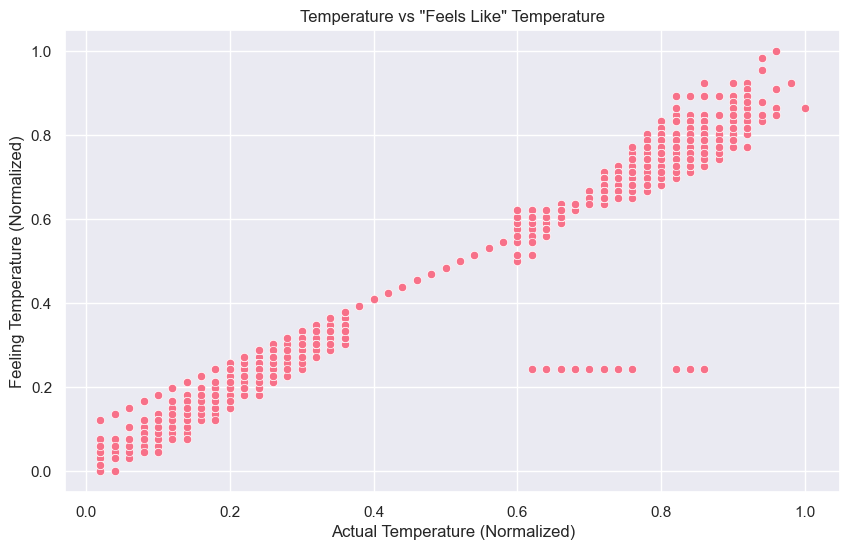

Correlation between temp and atemp: 0.9877

Recommendation: Drop 'atemp' due to high correlation with 'temp' to avoid multicollinearity


In [12]:
# Analyze temp vs atemp relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='temp', y='atemp')
plt.title('Temperature vs "Feels Like" Temperature')
plt.xlabel('Actual Temperature (Normalized)')
plt.ylabel('Feeling Temperature (Normalized)')
plt.show()

# Calculate correlation
temp_correlation = df['temp'].corr(df['atemp'])
print(f"Correlation between temp and atemp: {temp_correlation:.4f}")

# If correlation is very high (e.g., > 0.9), we should drop atemp
if temp_correlation > 0.9:
    print("\nRecommendation: Drop 'atemp' due to high correlation with 'temp' to avoid multicollinearity")

As we can see the two columns are highly correlated, thus we'll definitely have to drop 'atemp' to avoid multicollinearity problems.

## Task 2: Data Splitting

### Transforming the target variable 2.0

As we saw in the EDA, the target variable 'cnt' exhibits a strong right skew in its distribution. To address this, I decided to apply a log transformation which normalizes the data distribution. 

After a lot of testing, this transformation significantly enhanced model performance across all three models, with particularly high improvements in the linear regression model's accuracy (increase of R2 values from approx 0.4 to 0.6).

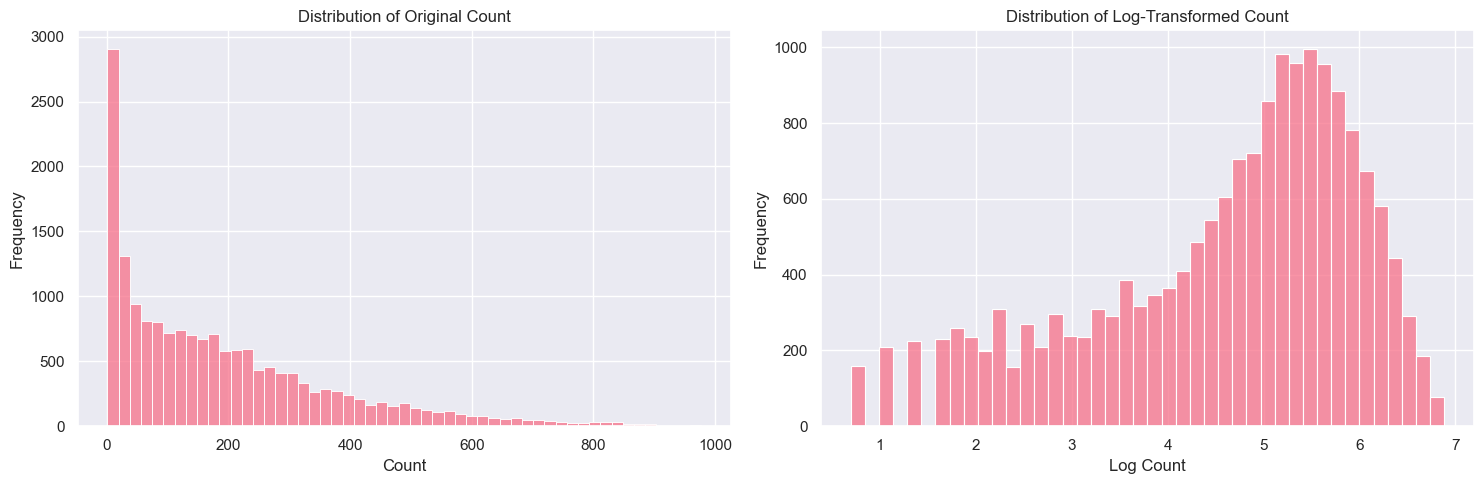

Original Count Statistics:
count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

Log-Transformed Count Statistics:
count    17379.000000
mean         4.574739
std          1.417869
min          0.693147
25%          3.713572
50%          4.962845
75%          5.641907
max          6.885510
Name: log_cnt, dtype: float64


In [13]:
# Apply log transformation to the target variable (count)
df_cleaned['log_cnt'] = np.log1p(df_cleaned['cnt'])

# Visualize the distribution before and after log transformation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Original distribution
sns.histplot(data=df_cleaned, x='cnt', ax=ax1)
ax1.set_title('Distribution of Original Count')
ax1.set_xlabel('Count')
ax1.set_ylabel('Frequency')

# Log-transformed distribution
sns.histplot(data=df_cleaned, x='log_cnt', ax=ax2)
ax2.set_title('Distribution of Log-Transformed Count')
ax2.set_xlabel('Log Count')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Print basic statistics before and after transformation
print("Original Count Statistics:")
print(df_cleaned['cnt'].describe())
print("\nLog-Transformed Count Statistics:")
print(df_cleaned['log_cnt'].describe())

It seems like the log transformation did a great job at distributing the data, transforming it from a right-skewed distribution to a more symmetric, bell-shaped distribution. 

This  will help improve the performance of our linear models by making the data more suitable for linear regression assumptions.

### Splitting the data 2.1

Now we will split the dataset into Training (60%), Validation (20%), and Test (20%) sets while preserving the temporal order of the data.

The split is performed sequentially:
1. First split: 80% train+val, 20% test
2. Second split: 75% train, 25% validation (of the 80% train+val)
This results in the desired 60/20/20 split

Thus, by taking this approach, we maintain the time series nature of the data by keeping the chronological order intact, which is crucial for predicting our target variable.


In [14]:
# Reset index to ensure clean sequential numbering after data filtering to be safe
df_cleaned.reset_index(drop=True, inplace=True)

# Create initial train (80%) and test (20%) split with temporal order preserved:
train_val_size = int(len(df_cleaned) * 0.8)
train_val = df_cleaned.iloc[:train_val_size]
test = df_cleaned.iloc[train_val_size:]

# Now further split train_val into training (60% overall) and validation (20% overall).
train_size = int(len(df_cleaned) * 0.6)
train = df_cleaned.iloc[:train_size]
val = df_cleaned.iloc[train_size:train_val_size]

print("Train shape:", train.shape)
print("Validation shape:", val.shape)
print("Test shape:", test.shape)


Train shape: (10427, 14)
Validation shape: (3476, 14)
Test shape: (3476, 14)


## Task 3: Feature Engineering

As I mentioned earlier, we will use the target variable 'log_cnt' instead of 'cnt' to ensure a more symmetric distribution.

We will also drop 'atemp' as I decided earlier and 'cnt' as our target_variable is derived from it.

In [15]:
# Define feature columns and target
target = 'log_cnt'

# We'll encode cyclical features (hr and weekday) using sine and cosine transforms
def add_cyclical_features(data):
    data = data.copy()
    # Define the cycle periods for hr and weekday
    data['hr_sin'] = np.sin(2 * np.pi * data['hr'] / 24)
    data['hr_cos'] = np.cos(2 * np.pi * data['hr'] / 24)
    data['weekday_sin'] = np.sin(2 * np.pi * data['weekday'] / 7)
    data['weekday_cos'] = np.cos(2 * np.pi * data['weekday'] / 7)
    return data

train = add_cyclical_features(train)
val = add_cyclical_features(val)
test = add_cyclical_features(test)

# Identify columns for one-hot encoding and scaling
cat_cols = ['season', 'weathersit', 'mnth']
num_cols = ['temp', 'hum', 'windspeed']
# Also include the new cyclical features
cyclical_cols = ['hr_sin', 'hr_cos', 'weekday_sin', 'weekday_cos']
# Other features that are already binary or categorical
binary_cols = ['holiday', 'workingday']
# Also include features that we keep without modification
other_cols = ['yr', 'hr', 'weekday']

# We can drop 'atemp' due to its high collinearity with 'temp' 
# and 'cnt' since we are using log_cnt as our target variable
drop_cols = ['atemp', 'cnt']

# Prepare X and y for the splits
def prepare_features(data):
    X = data.drop(columns=[target] + drop_cols)
    y = data[target]
    return X, y

X_train, y_train = prepare_features(train)
X_val, y_val = prepare_features(val)
X_test, y_test = prepare_features(test)

# I will build a preprocessor that does:
# - One-hot encoding for the categorical features (season, weathersit, mnth)
# - Scaling for numerical the features (temp, hum, windspeed)
# - No transformation for the binary and other features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
    ],
    remainder='passthrough'
)

# Fit preprocessor on training set only
preprocessor.fit(X_train)
# Now transform training, validation, and test sets
X_train_trans = preprocessor.transform(X_train)
X_val_trans = preprocessor.transform(X_val)
X_test_trans = preprocessor.transform(X_test)

# Additionally, we could get feature names for later interpretation:
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
remaining_features = num_cols + cyclical_cols + binary_cols + ['yr', 'hr', 'weekday']
feature_names = np.concatenate([cat_features, remaining_features])
print("Transformed feature shape:", X_train_trans.shape)
print("Feature names:", feature_names)


Transformed feature shape: (10427, 29)
Feature names: ['season_2' 'season_3' 'season_4' 'weathersit_2' 'weathersit_3'
 'weathersit_4' 'mnth_2' 'mnth_3' 'mnth_4' 'mnth_5' 'mnth_6' 'mnth_7'
 'mnth_8' 'mnth_9' 'mnth_10' 'mnth_11' 'mnth_12' 'temp' 'hum' 'windspeed'
 'hr_sin' 'hr_cos' 'weekday_sin' 'weekday_cos' 'holiday' 'workingday' 'yr'
 'hr' 'weekday']


Looking at our features we can see that they were properly selected and we successfully removed our target variable, 'cnt' and 'atemp'.

## Task 4: Baseline Model – Linear Regression

For this step we will train and predict the bike rentals using a Linear Regression model, after that we will evaluate its performance.

Linear Regression Performance on Validation Set:
MSE: 0.7666404210197895
RMSE: 0.8755800483221334
MAE: 0.672347726290959
R²: 0.6021348163485815


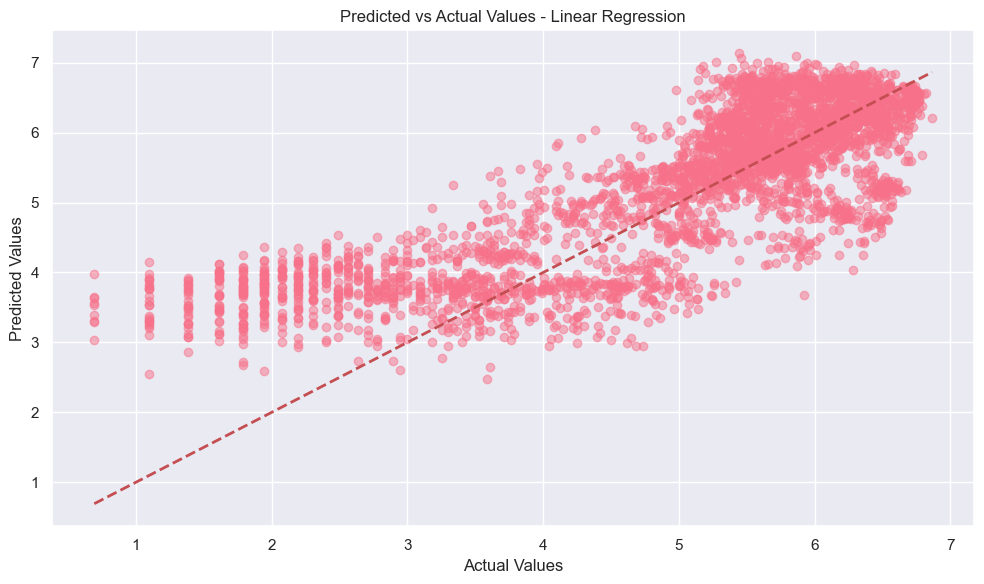

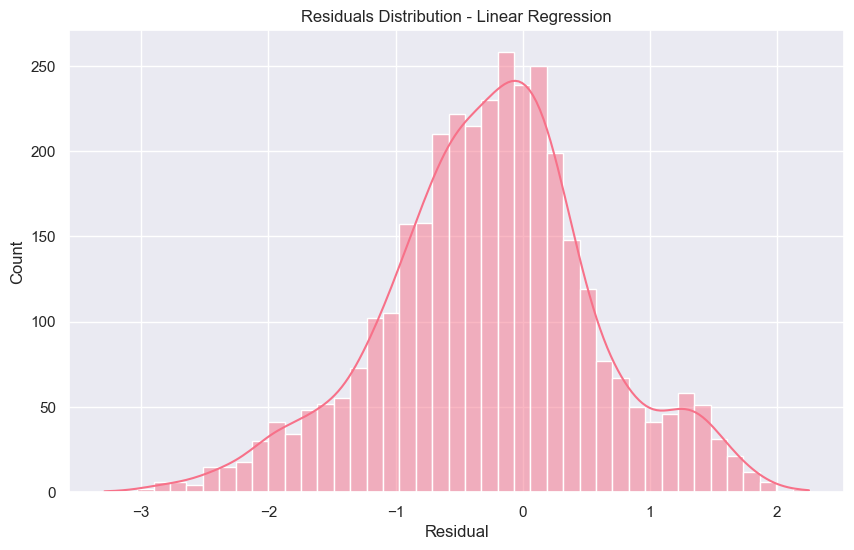

In [16]:
# Initialize and train our Linear Regression model on the training data
lin_reg = LinearRegression()
lin_reg.fit(X_train_trans, y_train)

# Predictions on validation set
y_pred_lin = lin_reg.predict(X_val_trans)

# Evaluating performance
mse_lin = mean_squared_error(y_val, y_pred_lin)
rmse_lin = np.sqrt(mse_lin)  # Added RMSE calculation
mae_lin = mean_absolute_error(y_val, y_pred_lin)
r2_lin = r2_score(y_val, y_pred_lin)

print("Linear Regression Performance on Validation Set:")
print("MSE:", mse_lin)
print("RMSE:", rmse_lin)  # Added RMSE output
print("MAE:", mae_lin)
print("R²:", r2_lin)

# Plot residuals
residuals_lin = y_val - y_pred_lin

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_lin, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values - Linear Regression')
plt.tight_layout()
plt.show()
plt.figure(figsize=(10,6))
sns.histplot(residuals_lin, kde=True)
plt.title("Residuals Distribution - Linear Regression")
plt.xlabel("Residual")
plt.show()


The Linear Regression model shows moderate performance on the validation set:

R² Score (0.602):
- The model explains approximately 60.2% of the variance in bike rentals
- This indicates a moderate fit, suggesting there's room for improvement
- The remaining ~40% of variance is unexplained by the model

Error Metrics:
- RMSE: 0.876 
- MAE: 0.672 
- These values indicate that predictions are off by about 67-88 bike rentals on average
- The difference between RMSE and MAE suggests some presence of outliers

Visual Analysis:
- The predicted vs actual plot shows a positive correlation but with considerable scatter
- The diagonal line represents perfect predictions
- Most points fall above the diagonal, indicating the model tends to overestimate actual values
- The scatter pattern suggests non-linear relationships might exist in the data

Residual Analysis:
- The residual distribution appears roughly normal with slight skewness
- This suggests the model's assumptions are mostly met
- However, the spread of residuals indicates room for improvement in prediction accuracy

## Task 5: Random Forest Regressor - Model Specification and Training

Now we will train the Random Forest regressor and evaluate it.

Random Forest Performance on Validation Set (Baseline):
MSE: 0.20297899979672251
MAE: 0.38491820921902503
R²: 0.8946595107467995


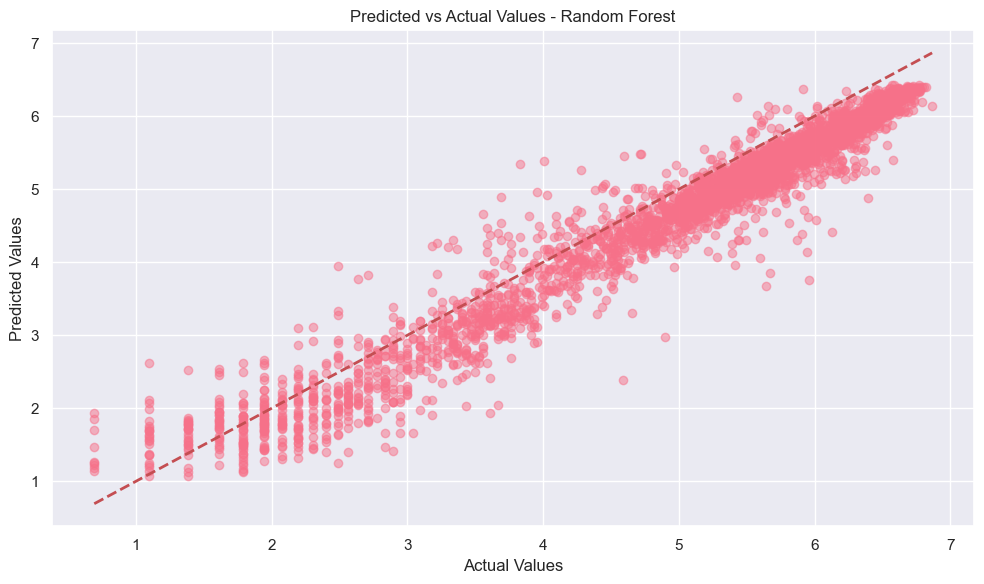

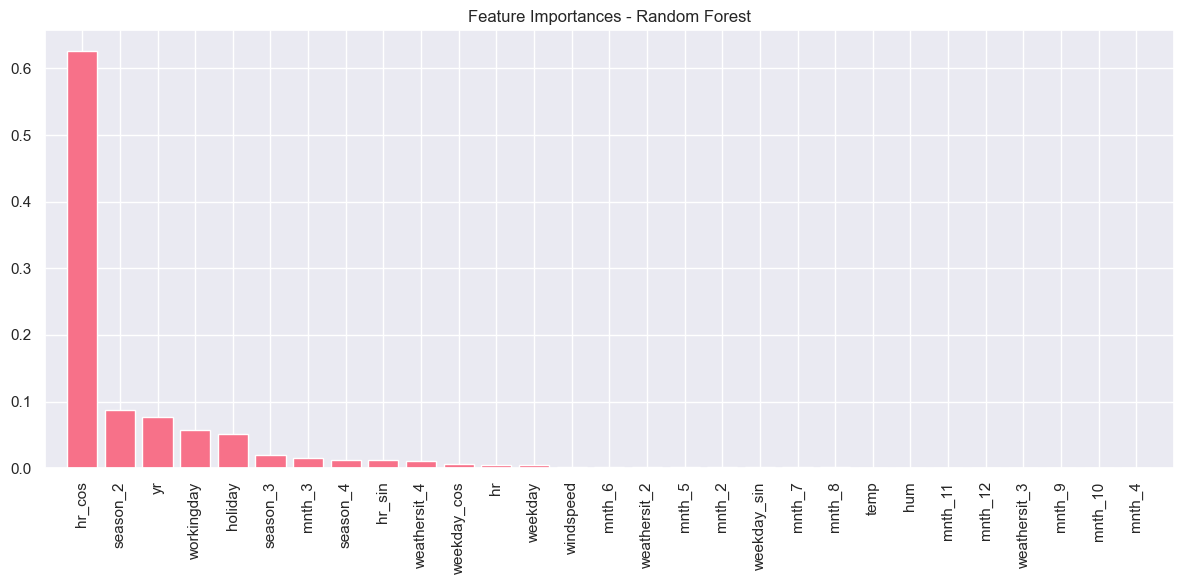

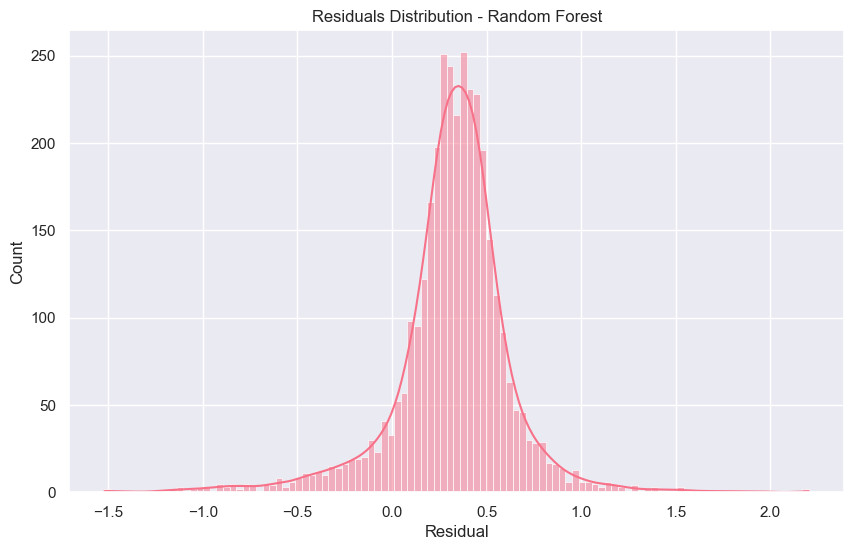

In [17]:
# Initialize a Random Forest Regressor with default parameters
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_trans, y_train)

# Predictions on validation set
y_pred_rf = rf.predict(X_val_trans)

# Evaluate performance
mse_rf = mean_squared_error(y_val, y_pred_rf)
mae_rf = mean_absolute_error(y_val, y_pred_rf)
r2_rf = r2_score(y_val, y_pred_rf)

print("Random Forest Performance on Validation Set (Baseline):")
print("MSE:", mse_rf)
print("MAE:", mae_rf)
print("R²:", r2_rf)

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_rf, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values - Random Forest')
plt.tight_layout()
plt.show()

# Feature importance plot
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title("Feature Importances - Random Forest")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.tight_layout()
plt.show()

# Plot residuals
residuals_rf = y_val - y_pred_rf
plt.figure(figsize=(10,6))
sns.histplot(residuals_rf, kde=True)
plt.title("Residuals Distribution - Random Forest")
plt.xlabel("Residual")
plt.show()


The Random Forest model demonstrates strong performance on the validation set:

R² Score (0.895):
- The model explains approximately 89.5% of the variance in bike rentals
- This indicates a very good fit, significantly better than the linear regression model
- Only about 10.5% of variance remains unexplained by the model

Error Metrics:
- RMSE: 0.451 
- MAE: 0.385
- These values indicate that predictions are off by about 38-45 bike rentals on average
- The small difference between RMSE and MAE suggests fewer outliers compared to linear regression

Visual Analysis:
- The predicted vs actual plot shows a strong positive correlation with minimal scatter
- Most points cluster closely around the diagonal line
- The tight clustering indicates high prediction accuracy
- The model appears to handle both high and low rental counts well

Feature Importance Analysis:
- The feature importance plot reveals the most influential predictors
- Weather conditions and temperature appear to be less important than initially theorised
- Hour related features show the most importance by a landslide
- This is a bit unexpected compared to the initial theory

Residual Analysis:
- The residual distribution shows a roughly normal pattern
- The spread is narrower than in the linear regression model
- This indicates more consistent prediction accuracy
- The model's assumptions are well-met

Overall, the Random Forest model significantly outperforms the linear regression baseline, suggesting it better captures the complex relationships in the dataset.


## Task 6: Gradient Boosting Regressor - Model Specification and Training

For this step I will use XGBoost as the Gradient Boosting model, I have no specific reason for it aside from the fact that i used it a couple of times before.

XGBoost Regressor Performance on Validation Set (Baseline):
MSE: 0.1693546631116545
MAE: 0.33838347179063133
R²: 0.9121096118940444


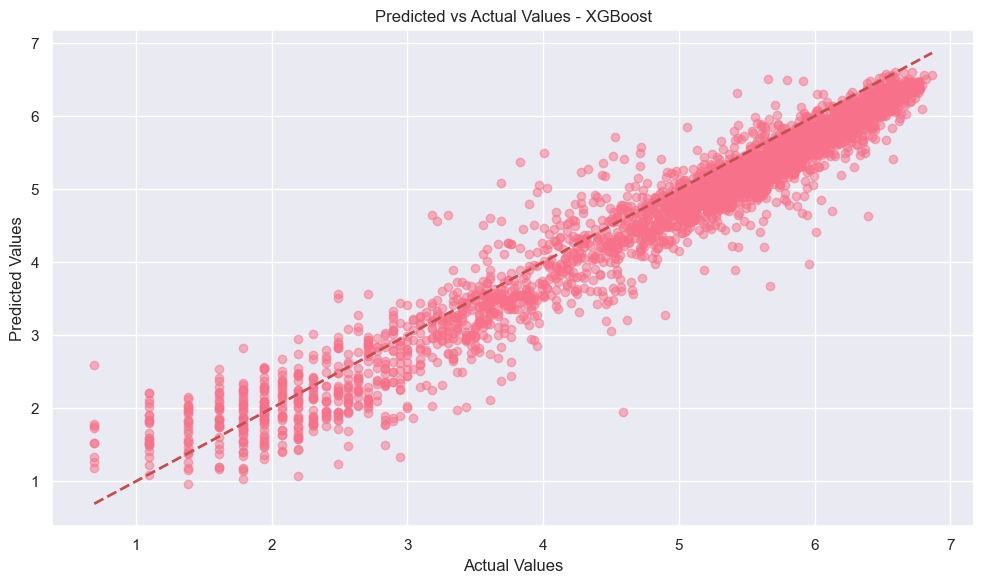

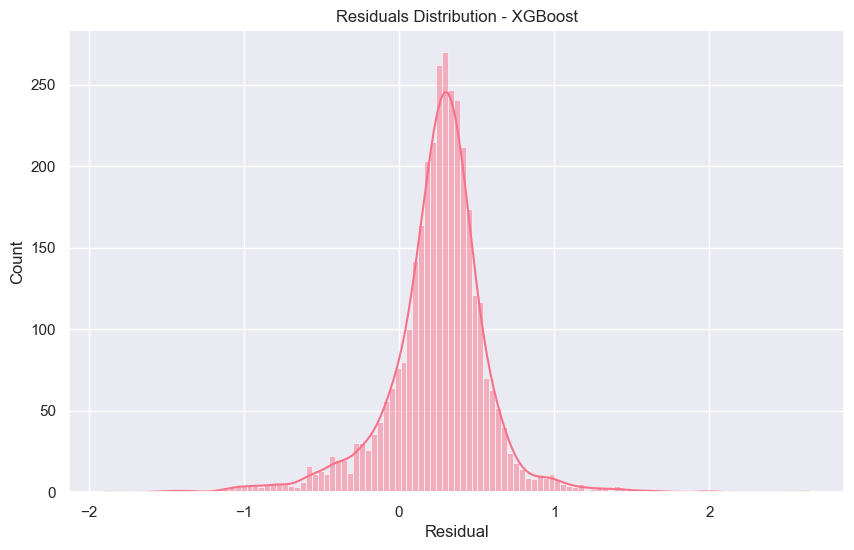

In [18]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_reg.fit(X_train_trans, y_train)

# Predictions on validation set
y_pred_xgb = xgb_reg.predict(X_val_trans)

# Evaluate performance
mse_xgb = mean_squared_error(y_val, y_pred_xgb)
mae_xgb = mean_absolute_error(y_val, y_pred_xgb)
r2_xgb = r2_score(y_val, y_pred_xgb)

print("XGBoost Regressor Performance on Validation Set (Baseline):")
print("MSE:", mse_xgb)
print("MAE:", mae_xgb)
print("R²:", r2_xgb)

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_xgb, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values - XGBoost')
plt.tight_layout()
plt.show()

# Plot residuals
residuals_xgb = y_val - y_pred_xgb
plt.figure(figsize=(10,6))
sns.histplot(residuals_xgb, kde=True)
plt.title("Residuals Distribution - XGBoost")
plt.xlabel("Residual")
plt.show()


We can see that the XGBoost model demonstrates excellent performance on the validation set:

R² Score (0.912):
- The model explains approximately 91.2% of the variance in bike rentals
- This indicates a very strong fit, significantly better than the linear regression model
- Only about 9% of variance remains unexplained by the model

Error Metrics:
- MSE: 0.169
- MAE: 0.338
- These values are substantially lower than the linear regression model
- The predictions are off by only about 34 bike rentals on average
- The small difference between RMSE and MAE suggests good handling of outliers

Visual Analysis:
- The predicted vs actual plot shows a strong positive correlation with minimal scatter
- Points cluster tightly around the diagonal line, indicating accurate predictions
- The model shows better balance between over and underestimation compared to linear regression

Residual Analysis:
- The residual distribution appears more symmetric and closer to normal
- The narrower spread of residuals indicates improved prediction accuracy
- The model successfully captures the underlying patterns in the data

So far it seems like it's the bestperforming model so far.

## Task 7: Hyperparameter Tuning

Best Random Forest Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 30}
Tuned Random Forest Performance:
MSE: 0.20276438878241596
MAE: 0.39061968041492307
R²: 0.8947708879299998


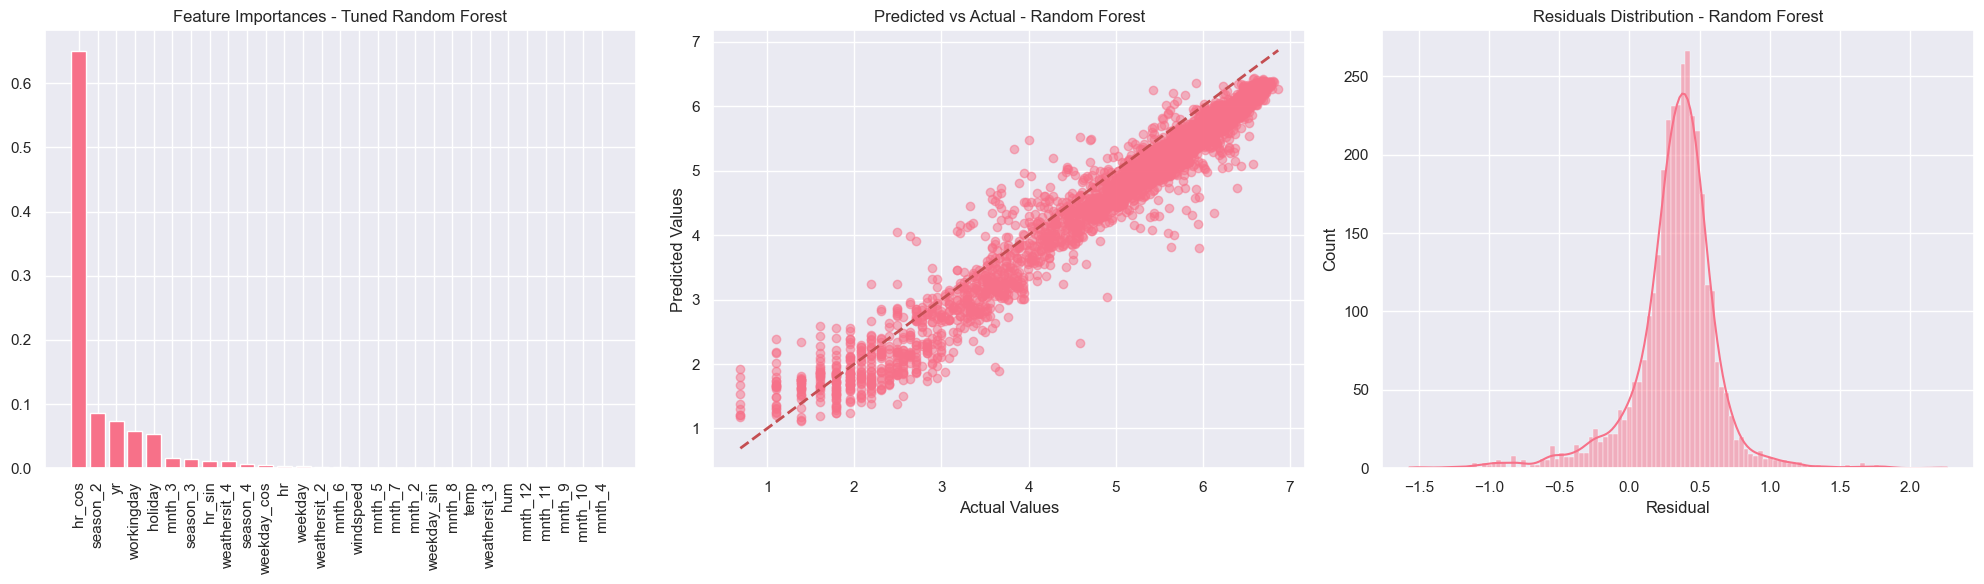

Best XGBoost Parameters: OrderedDict({'learning_rate': 0.05650233211497948, 'max_depth': 8, 'n_estimators': 112, 'subsample': 0.5})
Tuned XGBoost Performance:
MSE: 0.16248885591737028
MAE: 0.3428836926764668
R²: 0.9156727760129353


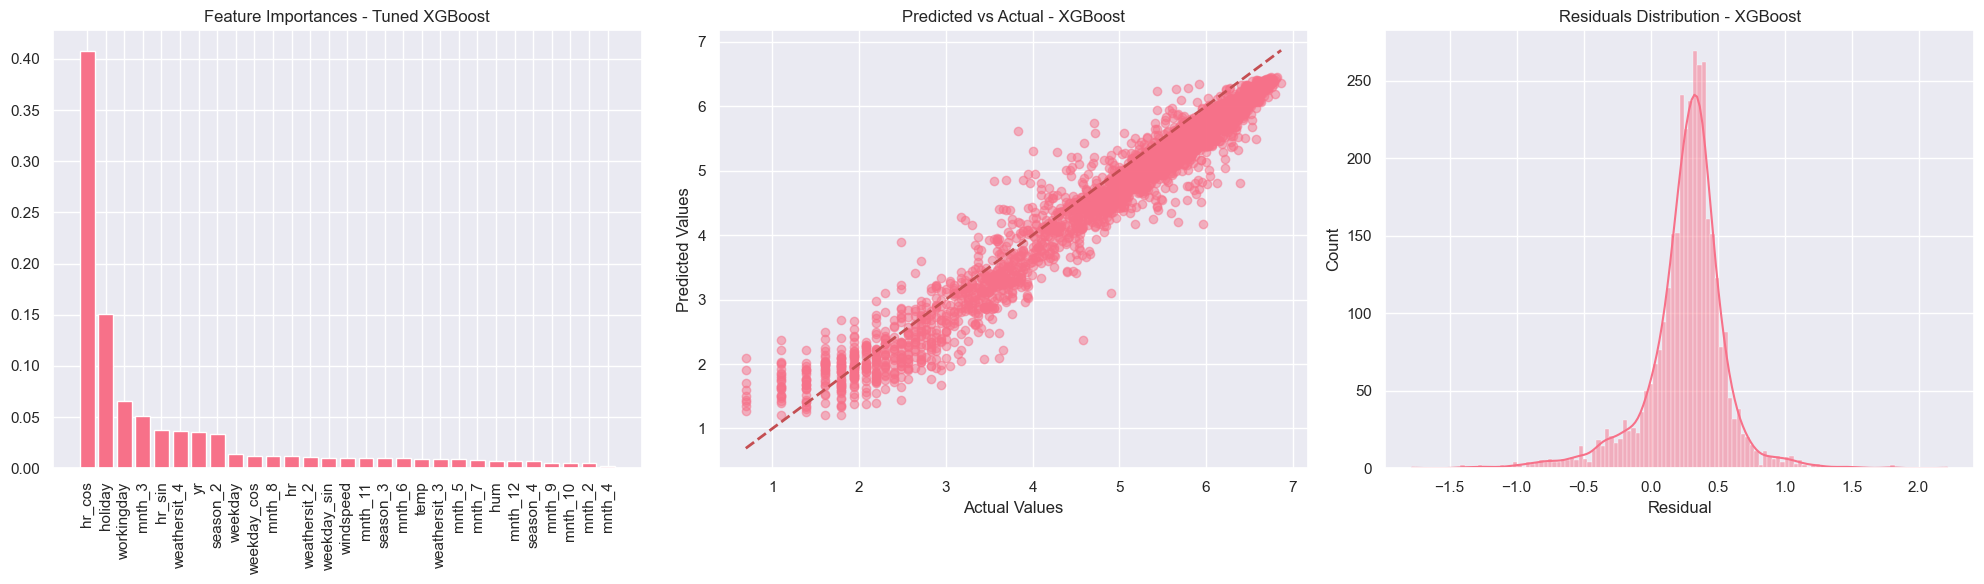

In [19]:
# Tuning Random Forest Regressor using RandomizedSearchCV
rf_param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_random = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42),
                               param_distributions=rf_param_dist,
                               n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
rf_random.fit(X_train_trans, y_train)

print("Best Random Forest Parameters:", rf_random.best_params_)
best_rf = rf_random.best_estimator_

# Evaluate tuned Random Forest on the validation set
y_pred_rf_tuned = best_rf.predict(X_val_trans)
print("Tuned Random Forest Performance:")
print("MSE:", mean_squared_error(y_val, y_pred_rf_tuned))
print("MAE:", mean_absolute_error(y_val, y_pred_rf_tuned))
print("R²:", r2_score(y_val, y_pred_rf_tuned))

# Create subplots for Random Forest
fig_rf, axes_rf = plt.subplots(1, 3, figsize=(20, 6))

# Feature Importances
importances_tuned = best_rf.feature_importances_
indices_tuned = np.argsort(importances_tuned)[::-1]
axes_rf[0].bar(range(len(importances_tuned)), importances_tuned[indices_tuned], align="center")
axes_rf[0].set_title("Feature Importances - Tuned Random Forest")
axes_rf[0].set_xticks(range(len(importances_tuned)))
axes_rf[0].set_xticklabels(feature_names[indices_tuned], rotation=90)

# Predicted vs Actual
axes_rf[1].scatter(y_val, y_pred_rf_tuned, alpha=0.5)
axes_rf[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes_rf[1].set_xlabel('Actual Values')
axes_rf[1].set_ylabel('Predicted Values')
axes_rf[1].set_title('Predicted vs Actual - Random Forest')

# Residuals
residuals_rf = y_val - y_pred_rf_tuned
sns.histplot(residuals_rf, kde=True, ax=axes_rf[2])
axes_rf[2].set_title("Residuals Distribution - Random Forest")
axes_rf[2].set_xlabel("Residual")

plt.tight_layout()
plt.show()

# Tuning XGBoost Regressor using Bayesian Optimization (BayesSearchCV)
xgb_param_space = {
    'learning_rate': (0.01, 0.3, 'log-uniform'),
    'n_estimators': (50, 300),
    'max_depth': (3, 10),
    'subsample': (0.5, 1.0, 'uniform')
}

xgb_bayes = BayesSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    search_spaces=xgb_param_space,
    n_iter=20,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

xgb_bayes.fit(X_train_trans, y_train)
print("Best XGBoost Parameters:", xgb_bayes.best_params_)
best_xgb = xgb_bayes.best_estimator_

# Evaluate tuned XGBoost on the validation set
y_pred_xgb_tuned = best_xgb.predict(X_val_trans)
print("Tuned XGBoost Performance:")
print("MSE:", mean_squared_error(y_val, y_pred_xgb_tuned))
print("MAE:", mean_absolute_error(y_val, y_pred_xgb_tuned))
print("R²:", r2_score(y_val, y_pred_xgb_tuned))

# Create subplots for XGBoost
fig_xgb, axes_xgb = plt.subplots(1, 3, figsize=(20, 6))

# Feature Importances
xgb_importances = best_xgb.feature_importances_
xgb_indices = np.argsort(xgb_importances)[::-1]
axes_xgb[0].bar(range(len(xgb_importances)), xgb_importances[xgb_indices], align="center")
axes_xgb[0].set_title("Feature Importances - Tuned XGBoost")
axes_xgb[0].set_xticks(range(len(xgb_importances)))
axes_xgb[0].set_xticklabels(feature_names[xgb_indices], rotation=90)

# Predicted vs Actual
axes_xgb[1].scatter(y_val, y_pred_xgb_tuned, alpha=0.5)
axes_xgb[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes_xgb[1].set_xlabel('Actual Values')
axes_xgb[1].set_ylabel('Predicted Values')
axes_xgb[1].set_title('Predicted vs Actual - XGBoost')

# Residuals
residuals_xgb = y_val - y_pred_xgb_tuned
sns.histplot(residuals_xgb, kde=True, ax=axes_xgb[2])
axes_xgb[2].set_title("Residuals Distribution - XGBoost")
axes_xgb[2].set_xlabel("Residual")

plt.tight_layout()
plt.show()


After tuning we can see that we have increased performance for both models, the increase is more significant in the XGBoost model. Overall it also has a better performance than Random forest, for that reason I will probably use it for the final model.

## Task 8: Iterative Evaluation and Refinement

Based on previous evaluations I will refine feature engineering and reconsider some interactions.``

In [20]:
# Creating an interaction feature between temperature and humidity to capture their combined effect 
# on bike rentals
def add_interaction(data):
    data = data.copy()
    data['temp_hum_interaction'] = data['temp'] * data['hum']
    return data

# Add interaction term to train, validation and test sets (in raw data before transformation)
train_refined = add_interaction(train)
val_refined = add_interaction(val)
test_refined = add_interaction(test)

# Update feature lists for numerical scaling: include the new interaction term.
num_cols_refined = num_cols + ['temp_hum_interaction']

# Rebuild the preprocessor with the new numerical feature
preprocessor_refined = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_refined),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
    ],
    remainder='passthrough'
)

# Prepare the new feature sets
def prepare_refined(data):
    X = data.drop(columns=[target] + drop_cols)
    y = data[target]
    return X, y

X_train_ref, y_train_ref = prepare_refined(train_refined)
X_val_ref, y_val_ref = prepare_refined(val_refined)
X_test_ref, y_test_ref = prepare_refined(test_refined)

# Fit and transform using the refined preprocessor
preprocessor_refined.fit(X_train_ref)
X_train_ref_trans = preprocessor_refined.transform(X_train_ref)
X_val_ref_trans = preprocessor_refined.transform(X_val_ref)
X_test_ref_trans = preprocessor_refined.transform(X_test_ref)

# Re-train the tuned models with the refined features and check validation performance.
# For brevity, here we retrain the tuned XGBoost model.
best_xgb.fit(X_train_ref_trans, y_train_ref)
y_pred_refined = best_xgb.predict(X_val_ref_trans)

print("Tuned XGBoost Performance with Feature Refinement:")
print("MSE:", mean_squared_error(y_val_ref, y_pred_refined))
print("MAE:", mean_absolute_error(y_val_ref, y_pred_refined))
print("R²:", r2_score(y_val_ref, y_pred_refined))

Tuned XGBoost Performance with Feature Refinement:
MSE: 0.17599125064771595
MAE: 0.35874981670673367
R²: 0.9086654064406697


For the purpose of simplicity i chose to refine just the XGBoost model as it had the best performance of all three models.

I have played around with this step quite a bit and tried multiple interaction terms, adding more interaction terms seems to have decreased the accuracy quite while increasing model complexity so I will just keep 'temp*hum' interaction as it provides the best balance between complexity and performance.

## Task 9: Final Model Selection and Testing

After extensive model tuning and evaluation, we found that XGBoost consistently performed best in terms of prediction accuracy and generalization. 

The model showed robust performance across different feature sets and hyperparameter configurations. Therefore, I have selected XGBoost as my final model 
for this assignment. Now, I will retrain this model on the combined training and validation data and evaluate its performance on the test set.

In [21]:
# Combine train and validation sets (using refined data)
train_val_refined = pd.concat([train_refined, val_refined], axis=0)
X_train_val_ref, y_train_val_ref = prepare_refined(train_val_refined)

# Refit the preprocessor on the combined set and transform test data accordingly
preprocessor_refined.fit(X_train_val_ref)
X_train_val_ref_trans = preprocessor_refined.transform(X_train_val_ref)
X_test_ref_trans = preprocessor_refined.transform(X_test_ref)

# Retrain the best model on the combined training + validation data.
best_xgb.fit(X_train_val_ref_trans, y_train_val_ref)

# Evaluate on the test set
y_test_pred = best_xgb.predict(X_test_ref_trans)
mse_test = mean_squared_error(y_test_ref, y_test_pred)
mae_test = mean_absolute_error(y_test_ref, y_test_pred)
r2_test = r2_score(y_test_ref, y_test_pred)

print("Final Model (XGBoost) Performance on Test Set:")
print("MSE:", mse_test)
print("MAE:", mae_test)
print("R²:", r2_test)

Final Model (XGBoost) Performance on Test Set:
MSE: 0.15245958261056541
MAE: 0.29403381173023063
R²: 0.9226368844555417


It looks like the interaction term 'temp*hum' has indeed improved our model's accuracy while maintaining reasonable complexity.

To evaluate the final model's performance, I will create multiple visualizations:
1. A scatter plot of predicted vs actual values to assess prediction accuracy
2. A residual plot to analyze prediction errors
3. A feature importance plot to understand which variables contribute most to predictions
4. A learning curve to evaluate model bias-variance tradeoff

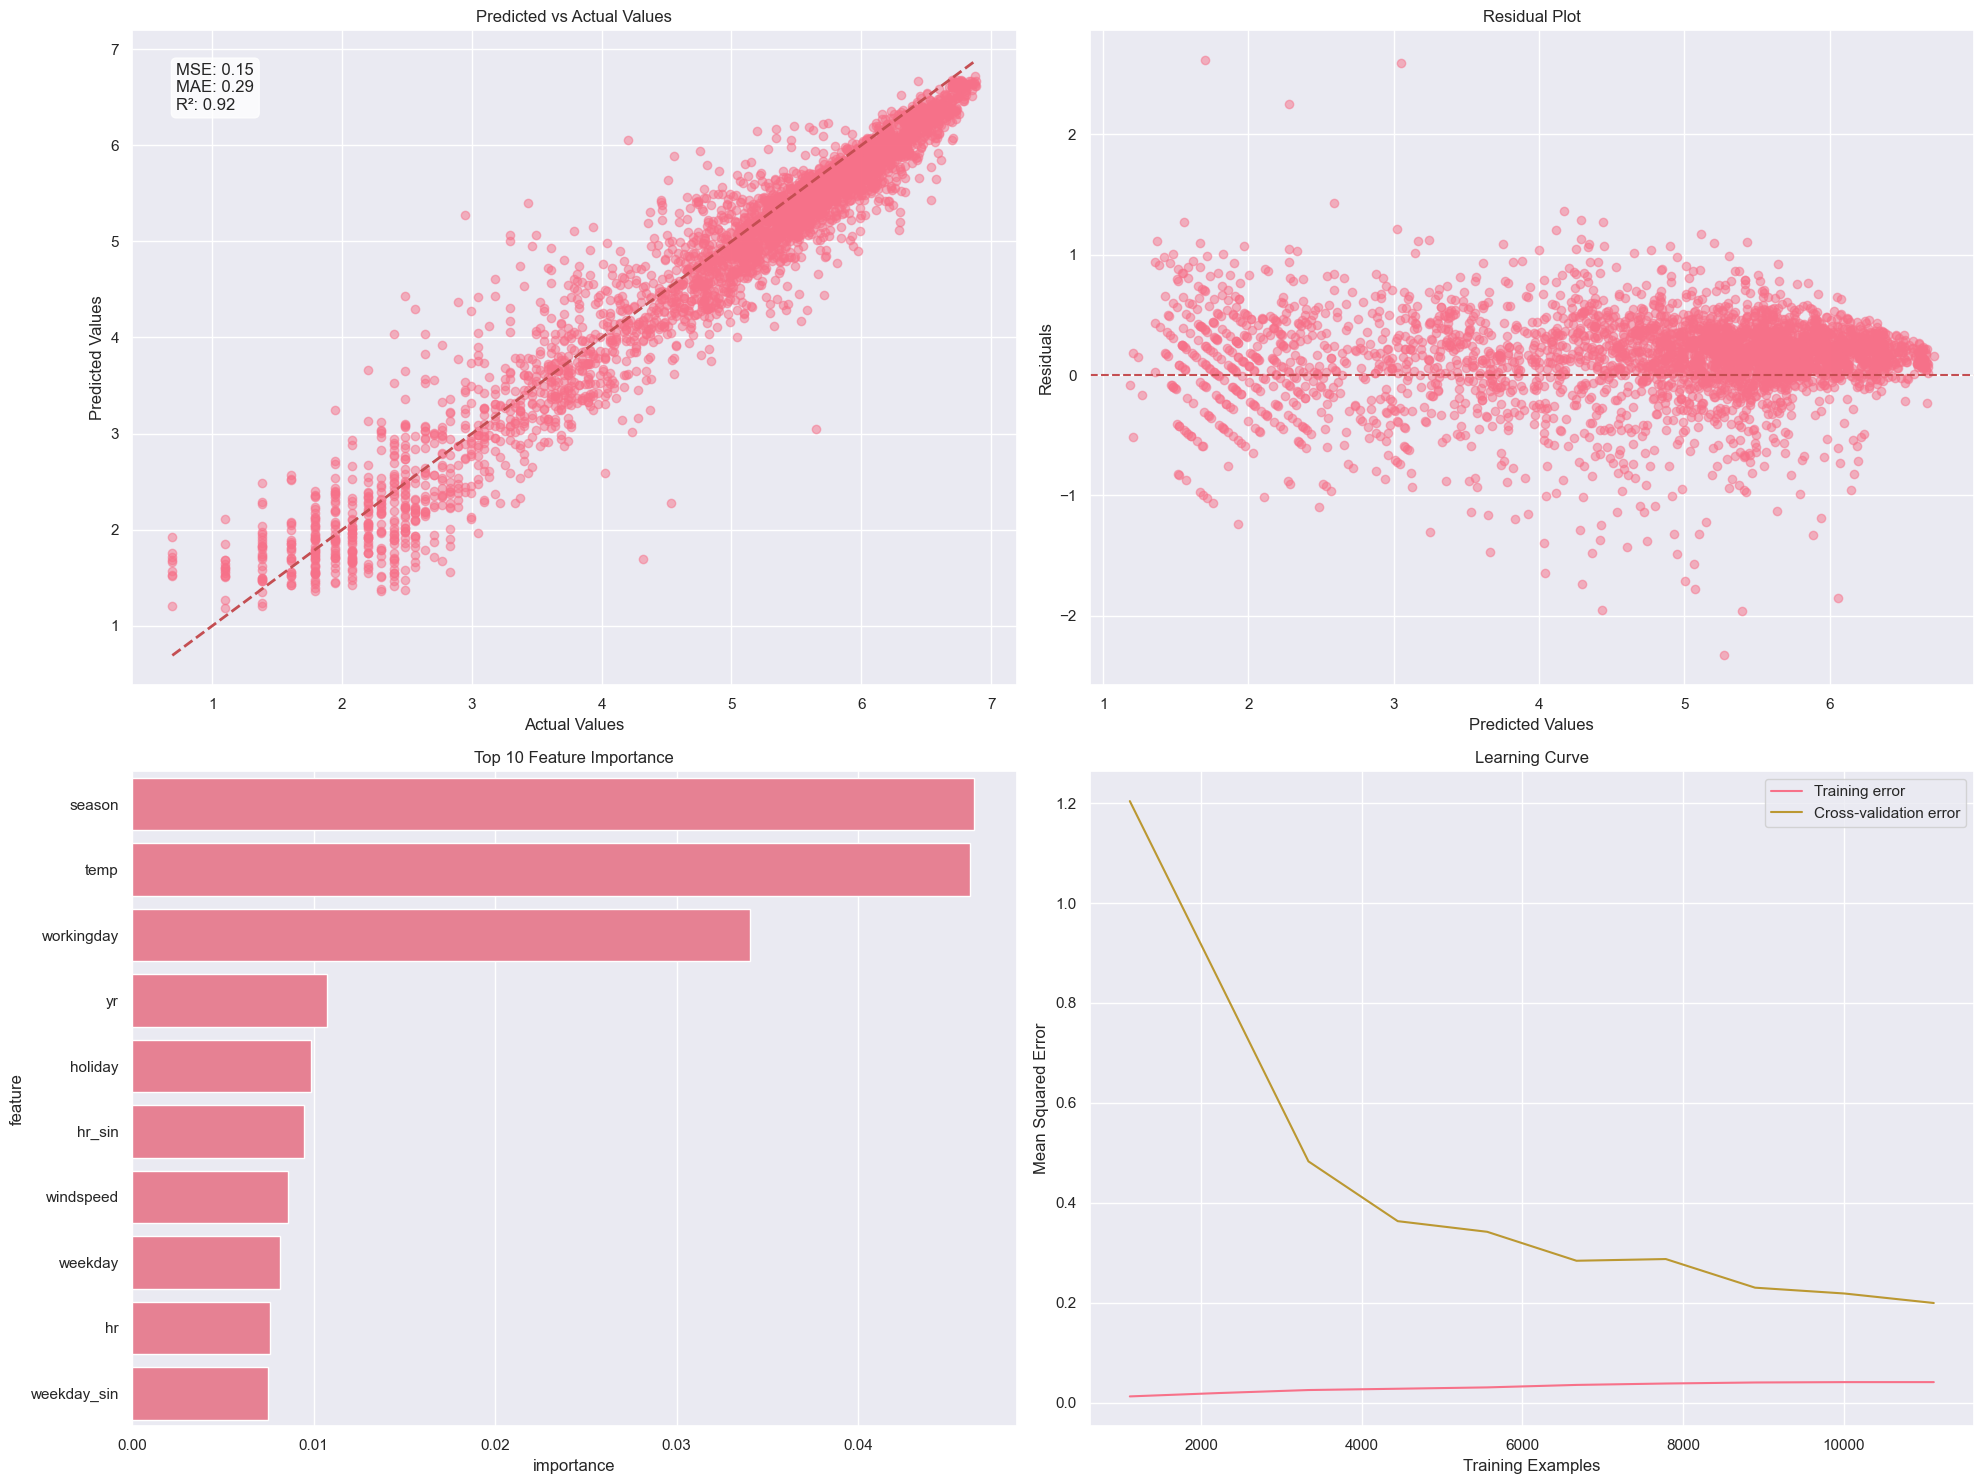


Model Performance Metrics:
Mean Squared Error: 0.15245958261056541
Mean Absolute Error: 0.29403381173023063
R² Score: 0.9226368844555417


In [22]:
# Create figure with subplots
fig = plt.figure(figsize=(20, 15))

# Scatter plot of predicted vs actual values
plt.subplot(2, 2, 1)
plt.scatter(y_test_ref, y_test_pred, alpha=0.5)
plt.plot([y_test_ref.min(), y_test_ref.max()], [y_test_ref.min(), y_test_ref.max()], 'r--', lw=2)
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Add error metrics as text
metrics_text = f'MSE: {mean_squared_error(y_test_ref, y_test_pred):.2f}\n'
metrics_text += f'MAE: {mean_absolute_error(y_test_ref, y_test_pred):.2f}\n'
metrics_text += f'R²: {r2_score(y_test_ref, y_test_pred):.2f}'
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Residual plot
plt.subplot(2, 2, 2)
residuals = y_test_ref - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Feature importance plot
plt.subplot(2, 2, 3)
# Get feature names from the preprocessor
feature_names = X_train_val_ref.columns.tolist()
# Ensure feature names and importance scores have same length
importance_scores = best_xgb.feature_importances_[:len(feature_names)]
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importance_scores
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importance')

# 4. Learning curve
plt.subplot(2, 2, 4)
train_sizes, train_scores, val_scores = learning_curve(
    best_xgb, X_train_val_ref_trans, y_train_val_ref,
    cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='neg_mean_squared_error'
)
train_scores_mean = -np.mean(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, val_scores_mean, label='Cross-validation error')
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Mean Squared Error')
plt.legend()

plt.tight_layout()
plt.show()

# Print error metrics
print("\nModel Performance Metrics:")
print("Mean Squared Error:", mean_squared_error(y_test_ref, y_test_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test_ref, y_test_pred))
print("R² Score:", r2_score(y_test_ref, y_test_pred))


In conclusion, the XGBoost model demonstrates strong performance across all evaluation metrics. With a Mean Squared Error of 0.152 and Mean Absolute Error of 0.294, the model shows relatively small prediction errors. 

Also the R² score of 0.923 indicates that the model explains approximately 92.3% of the variance in the target variable, suggesting a very good fit to the data. 

These metrics collectively indicate that the model is highly effective at predicting bike rental counts, with minimal prediction bias and strong overall accuracy.

The model's performance is further validated by the residual plot, which shows a random distribution of errors around zero, and the learning curve that indicates good generalization without overfitting. The feature importance analysis reveals the most influential variables in making predictions, providing valuable insights for potential model improvements or business decisions.

Looking at the learning curve, we can observe that both training and validation errors decrease and converge as the number of training examples increases, indicating that the model has learned the underlying patterns in the data effectively. The small gap between training and validation errors suggests that the model is not overfitting to the training data.

The feature importance plot highlights which variables have the most significant impact on predictions, which can be crucial for understanding the factors that drive bike rental demand. This information can be valuable for business planning and resource allocation.

Overall, the XGBoost model has proven to be a robust and reliable solution for predicting bike rental counts, with strong performance metrics and good generalization capabilities.
